In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os, json
import torch
from tqdm import tqdm
from natsort import natsorted

In [3]:
from src.scripts.models.U2Net import U2Net 
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda'
BATCH_SIZE = 2

## 1. Load EchoNet Dataset

Now we have only 2 fited models. "LV", "RV"

In [4]:
from src.scripts.DataLoaders import ImgForPlot

In [5]:
def get_data(img_paths: list, msk_paths, img_shape=(512, 512), mask_class='LA'):
    """ img_shape - Output image size. Without channels. """

    color = (255, 255, 255)

    n_photo = len(img_paths)      # Batch size
    images = []
    masks = []
    
    for im_path, m_path in tqdm(zip(img_paths, msk_paths), total=n_photo):
        # Open mhd
        image = cv2.imread(im_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #
        mask = np.zeros(image.shape[:2])
        with open(m_path) as f:
            lbl = json.load(f)
        for key, vals in lbl.items():
            if key == mask_class:
                points = np.array([[[xi, yi]] for yi, xi in vals]).astype(np.int32)
                mask = cv2.fillPoly(mask, [points], color=[255,255,255])
                 
        # Resize
        if img_shape:
            # 
            image = cv2.resize(image, dsize=img_shape, interpolation=cv2.INTER_CUBIC)  # INTER_CUBIC
            image = np.clip(image, 0, None)
            image = image / image.max()   # (843, 512, 3)

            mask = cv2.resize(mask, dsize=img_shape, interpolation=cv2.INTER_CUBIC)  # INTER_CUBIC
            mask = np.clip(mask, 0, None)
            mask = mask / mask.max()   # (843, 512, 3)
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)
        # If we want visualize
        # image = np.transpose(image, (1, 2, 0)) 
        image = np.transpose(image, (2, 0, 1)) 
        mask = np.transpose(mask, (2, 0, 1)) 
        # image = np.expand_dims(image, axis=0)  # (1, 3, 512, 512)

        images.append(image)
        masks.append(mask)
        # break
    return np.array(images).astype(np.float32), np.array(masks).astype(np.float32)

In [9]:
# All paths
main_ds_path = 'data/raw/Mini-EchoNet-Dynamic'
im_main_path = os.path.join(main_ds_path, 'Images')
msk_main_path = os.path.join(main_ds_path, 'MasksJsonContours')
# Obtrain sorted path to data
img_paths = [os.path.join(im_main_path, im_name) for im_name in natsorted(os.listdir(im_main_path))]
msk_paths = [os.path.join(msk_main_path, im_name) for im_name in natsorted(os.listdir(msk_main_path))]
msk_paths[:5]

['data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara1.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara2.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara3.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara4.json',
 'data/raw/Mini-EchoNet-Dynamic/MasksJsonContours/mascara5.json']

100%|██████████| 100/100 [00:00<00:00, 309.32it/s]


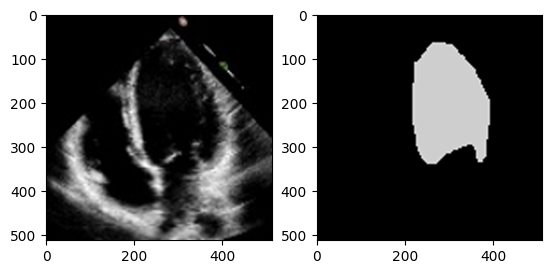

In [10]:
#
lv_images, lv_masks = get_data(img_paths, msk_paths, img_shape=(512, 512), mask_class='LV')
la_images, la_masks = get_data(img_paths, msk_paths, img_shape=(512, 512), mask_class='LA')

plt.subplot(121)
plt.imshow(np.transpose(lv_images[1], (1, 2, 0)));
plt.subplot(122)
plt.imshow(np.transpose(lv_masks[1], (1, 2, 0)), 'gray');

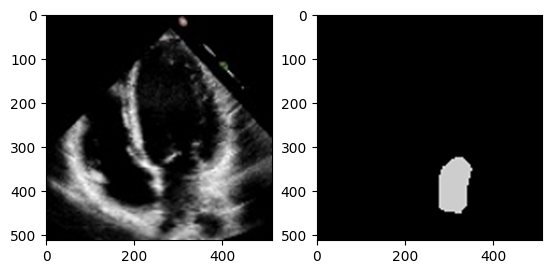

In [11]:
plt.subplot(121)
plt.imshow(np.transpose(la_images[1], (1, 2, 0)));
plt.subplot(122)
plt.imshow(np.transpose(la_masks[1], (1, 2, 0)), 'gray');

## 2. Load models

LA

In [6]:
model_name = 'u2net-LA'
model_saved_dir = 'results/U2Net'

model_path = F"{model_saved_dir}/{model_name}_best.pt"  # _best

model = U2Net().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
indx = 0

im = torch.from_numpy(np.expand_dims(la_images[indx], axis=0))
m = la_masks[indx]
predict = model(im.to(device))[-1]
pred = prepare_output(predict)
pred.shape, m.shape

((512, 512, 1), (1, 512, 512))

In [12]:
# im.shape, predict.shape

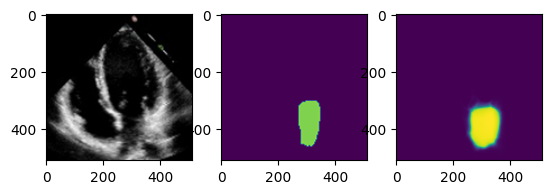

In [13]:
plt.subplot(131)
plt.imshow(np.transpose(im[0], (1, 2, 0)));
plt.subplot(132)
plt.imshow(np.transpose(m, (1, 2, 0)));
plt.subplot(133)
plt.imshow(pred);

In [14]:
# Dice similarity function
def dice(pred, true, k = 1):
    # sigmoid out
    # pred = 1 / (1 + np.exp(-pred))
    pred = np.where(pred > 0.5, 1, 0)
    true = np.where(true > 0.01, 1, 0)

    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [15]:
la_images.shape, la_masks.shape

((100, 3, 512, 512), (100, 1, 512, 512))

In [16]:
dice_sum = 0

for la_img, la_msk in zip(la_images, la_masks):
    la_img = torch.from_numpy(np.expand_dims(la_img, 0))
    predict = prepare_output(model(la_img.to(device))[-1])
    dice_sum += dice(predict, np.transpose(la_msk, (1, 2, 0)))

dice_sum / 100

np.float64(0.8151692794143005)

In [16]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read()
print(frame.shape)

(944, 1392, 3)


[mjpeg @ 0x5f21b7c69280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5f21b7c74a40] unable to decode APP fields: Invalid data found when processing input


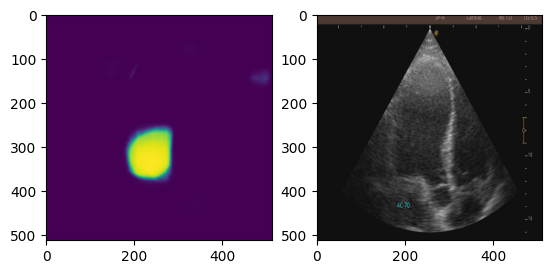

In [17]:
new_img = prepare_input(frame[50:, 150:, :])
pred = model(new_img.to(device))[-1]
pred = prepare_output(pred)

plt.subplot(121)
plt.imshow(pred)
plt.subplot(122)
plt.imshow(cv2.resize(frame[50:, 150:, :], dsize=(512, 512)));

### LV

In [18]:
model_name = 'u2net-LV'
model_saved_dir = 'results/U2Net'

model_path = F"{model_saved_dir}/{model_name}_best.pt"  # _best

model = U2Net().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [19]:
indx = 0

im = torch.from_numpy(np.expand_dims(lv_images[indx], axis=0))
m = lv_masks[indx]
predict = model(im.to(device))[-1]
pred = prepare_output(predict)
pred.shape, m.shape

((512, 512, 1), (1, 512, 512))

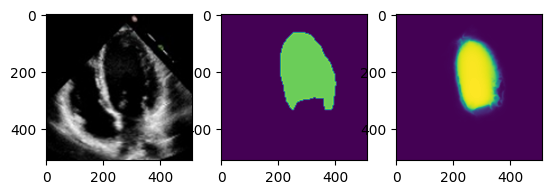

In [20]:
plt.subplot(131)
plt.imshow(np.transpose(im[0], (1, 2, 0)));
plt.subplot(132)
plt.imshow(np.transpose(m, (1, 2, 0)));
plt.subplot(133)
plt.imshow(pred);

In [21]:
dice_sum = 0

for lv_img, lv_msk in zip(lv_images, lv_masks):
    lv_img = torch.from_numpy(np.expand_dims(lv_img, 0))
    predict = prepare_output(model(lv_img.to(device))[-1])
    dice_sum += dice(predict, np.transpose(lv_msk, (1, 2, 0)))

dice_sum / 100

KeyboardInterrupt: 

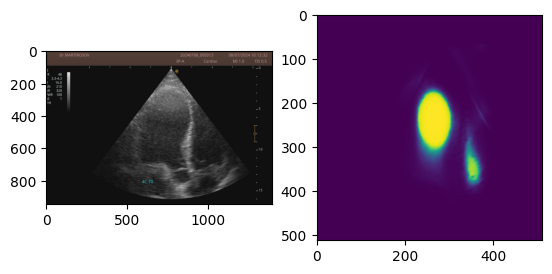

In [30]:


im1 = prepare_input(frame)
# m1 = lv_masks[indx]
predict = model(im1.to(device))[-1]
pred = prepare_output(predict)

plt.subplot(121)
plt.imshow(frame)
plt.subplot(122)
plt.imshow(pred)

## 3. Open Big Vesion

In [22]:
import pandas as pd
import os

In [23]:
def read_video(video_path):
    """ 
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if not ret:
            break
        frames.append(frame)
    cap.release()

    return frames

In [25]:
main_path = 'data/raw/EchoNet-Dynamic'

label_df = pd.read_csv(os.path.join(main_path, 'VolumeTracings.csv'))
# Sorted by name and frame
label_df = label_df.sort_values(['FileName', 'Frame'])
label_df.head(10)

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46
5,0X100009310A3BD7FC.avi,47.962105,29.759513,65.810920,25.221679,46
6,0X100009310A3BD7FC.avi,48.167915,32.723188,68.247043,27.618326,46
7,0X100009310A3BD7FC.avi,48.373726,35.686864,70.385311,30.090698,46
8,0X100009310A3BD7FC.avi,48.579537,38.650539,72.523579,32.563071,46
9,0X100009310A3BD7FC.avi,49.014039,41.556073,74.151644,35.165156,46


In [26]:
file_names = {}
for filename in label_df['FileName'].unique():
    file_names[filename] = os.path.join(os.path.join(main_path, 'Videos', filename))

file_names[filename]

'data/raw/EchoNet-Dynamic/Videos/0XFEBEEFF93F6FEB9.avi'

In [61]:
frames = []
targets = []
i = 0

for file_name, file_path in file_names.items():
    print(file_name)
    cap = cv2.VideoCapture(file_path)
    df = label_df[label_df['FileName'] == file_name]
    frame_numbers = df['Frame'].unique()
    for f_num in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, f_num-1)
        res, frame = cap.read()
        target = np.concat([df[['X1', 'Y1']], df[['X2', 'Y2']]],0)

        frames.append(frame)
        targets.append(target)
    i += 1
    if i > 6:
        break

0X100009310A3BD7FC.avi
0X1002E8FBACD08477.avi
0X1005D03EED19C65B.avi
0X10075961BC11C88E.avi
0X10094BA0A028EAC3.avi
0X100CF05D141FF143.avi
0X100E3B8D3280BEC5.avi


In [62]:
targets, frames

([array([[51.26041667, 15.34895833],
         [50.03761083, 17.16784126],
         [49.15737821, 20.40762939],
         [48.5381733 , 23.58105455],
         [47.91896839, 26.7544797 ],
         [47.9621045 , 29.75951307],
         [48.16791529, 32.72318847],
         [48.37372608, 35.68686387],
         [48.57953687, 38.65053927],
         [49.01403934, 41.55607271],
         [49.83099892, 44.3643713 ],
         [50.64795851, 47.17266989],
         [51.4649181 , 49.98096847],
         [52.54732826, 52.72177963],
         [53.7042693 , 55.44364225],
         [54.36563   , 58.29149988],
         [51.15135239, 62.12468928],
         [49.33671909, 65.6020369 ],
         [50.3482871 , 68.36085877],
         [57.51297555, 69.55532799],
         [71.93835296, 68.90385933],
         [56.        , 19.54166667],
         [55.61529756, 20.69577397],
         [54.99178009, 22.98490627],
         [54.48652146, 25.25857011],
         [54.32053727, 27.48785628],
         [54.69067898, 29.64701628],
 

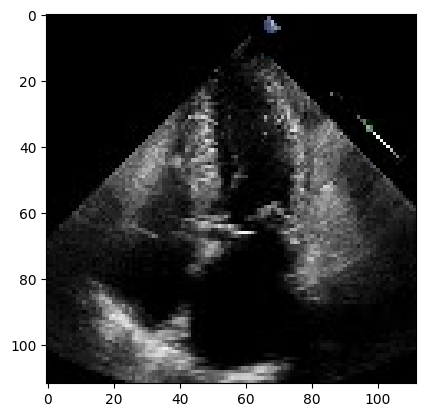

In [63]:
plt.imshow(frames[1])

In [64]:
targets[0].shape
# points1 = np.array([[[xi, yi]] for xi, yi in targets[0][:, :2]]).astype(np.int32)
# points2 = np.array([[[xi, yi]] for xi, yi in targets[0][:, 2:]]).astype(np.int32)

(84, 2)

(84, 1, 2)


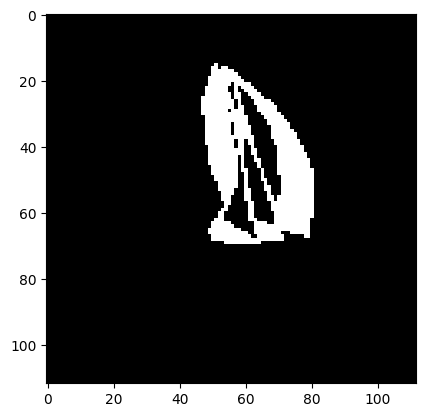

In [65]:
# mask = frames[0].copy()
mask = np.zeros_like(frames[0])

points = np.array([[[xi, yi]] for xi, yi in targets[0][:, :2]]).astype(np.int32)
# points = points.sort_values(['x', 'y'])
print(points.shape)
mask = cv2.fillPoly(mask, [points], color=[255,255,255])
# mask = cv2.fillPoly(mask, [points], color=[255,255,255])
plt.imshow(mask);

In [68]:
len(targets), targets[0].shape, len(frames), len(frames[1].shape)

(14, (84, 2), 14, 3)

In [127]:
des.shape

(112, 112, 3)

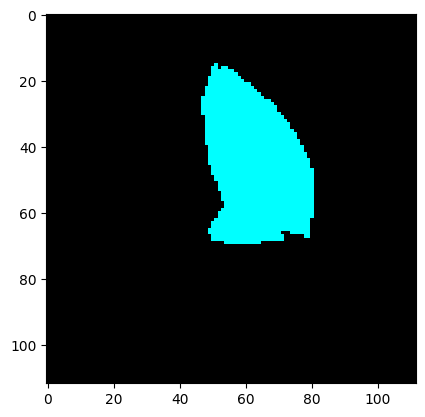

In [130]:
des = cv2.bitwise_not(mask)
contour, hier = cv2.findContours(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    cv2.drawContours(des, [cnt], 0, 255, -1)

gray = cv2.bitwise_not(des)
plt.imshow(gray)

In [48]:
df = label_df[label_df['FileName'] == file_name]
df.head(2)

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.12500,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.32133,46


In [52]:
target = np.concat([df[['X1', 'Y1']], df[['X2', 'Y2']]], axis=0)
target = pd.DataFrame(target, columns=['X', 'Y'])
target = target.sort_values("X")
target

,X,Y
4,47.918968,26.754480
5,47.962105,29.759513
6,48.167915,32.723188
7,48.373726,35.686864
3,48.538173,23.581055
...,...,...
60,80.065451,60.805648
56,80.326055,48.675392
59,80.431214,57.696657
57,80.609375,51.619361


(84, 1, 2)


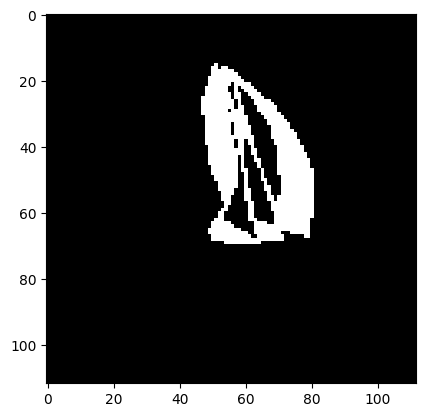

In [59]:
# mask = frames[0].copy()
mask = np.zeros_like(frames[0])

points = np.array([[[target.X[i], target.Y[i]]] for i in range(len(target))]).astype(np.int32)
# points = points.sort_values(['x', 'y'])
print(points.shape)
mask = cv2.fillPoly(mask, [points], color=[255,255,255])
# mask = cv2.fillPoly(mask, [points], color=[255,255,255])
plt.imshow(mask);